In [118]:
import backtrader as bt

import backtrader.indicators as btind
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import math
from sklearn import preprocessing
from math import sqrt
from technicalSignals import momentum,SMA,inBBands


In [119]:
tickers=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       


meanprice=list()
for ticker in tickers:
    price=pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/GMT+0/'+ticker+'.csv')
    meanprice.append(price['open'].iloc[math.floor(len(price)*0.9)])
print(meanprice)

[187.31, 1581.57, 100.0, 1080.44, 97.4647, 183.88, 54.49, 43.84, 32.57, 241.99, 332.93, 2130.65, 239.21, 178.69, 111.27, 239.442, 80.34, 68.21, 199.1278, 57.42]


In [124]:
# ===========================================    Trading Library utilities

    
# class Sizer(bt.Sizer):
#     params = dict(stake=1)

#     def _getsizing(self, comminfo, cash, data, isbuy):
#         dt, i = self.strategy.datetime.date(), data._id
#         s = self.p.stake * (1 + (not isbuy))
#         print('{} Data {} OType {} Sizing to {}'.format(
#             dt, data._name, ('buy' * isbuy) or 'sell', s))

#         return s

    
class Strategy(bt.Strategy):
    params = dict(
        pred_threshold = None,        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
        num_pred_over_threshold = None, #buy if more than this number of prediction over threshold
        forecast_window = None,
        pred_threshold_pos=None,
        pred_threshold_neg=None,
        predictions = None,
        verbose = None,
        tol=None,
        value=None
    )

    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if self.verbose:
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        
    def __init__(self):
        self.planned_sell = {}  # PLANNED SELL FOR EACH BUY AFTER TREND WINDOW dict: selldate, stock -> amount
        self.forecast_window = self.params.forecast_window
        self.predictions = self.params.predictions
        self.pred_threshold=self.params.pred_threshold
        
        self.num_pred_over_threshold = self.params.num_pred_over_threshold
        self.verbose = self.params.verbose
        self.tol = self.params.tol
        self.value=self.params.value
        

    def next(self): 
        positions = {}
        for i, d in enumerate(self.datas):
            #dt = self.datetime.date()
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            
            if(len((np.where(self.predictions[i]['Unnamed: 0']==dt)[0]))>0):
                time_idx = np.where(self.predictions[i]['Unnamed: 0']==dt)[0][0]
                dn = d._name
                ticker_pred = self.predictions[i][d._name][time_idx]

                previous_pred = self.predictions[i][d._name].iloc[time_idx-self.num_pred_over_threshold:time_idx]

                previous_pred_pos = sum([1 if p>0.5+self.pred_threshold else 0 for p in previous_pred]) #count prev over threshold
                previous_pred_neg = sum([1 if p<0.5-self.pred_threshold else 0 for p in previous_pred])
                pos = self.getposition(d).size
                positions[dn]=pos
                # Strategy: buy if abs(pred)> threshold or if more than n predictions positive
                quantity=math.ceil(self.value/(140*len(tickers)*meanprice[i]))*10
                
                
                if(ticker_pred>self.pred_threshold+0.5 or ticker_pred<0.5-self.pred_threshold):
                    # Buy and set planned sell if prediction positive
                    if(ticker_pred > 0.5 and previous_pred_pos>=self.num_pred_over_threshold*self.tol):
                        self.buy(data = d, size=quantity)                
                        idx_to_sell = time_idx+self.forecast_window
                        self.planned_sell[(dn,idx_to_sell)] = quantity
                    elif(ticker_pred<0.5 and previous_pred_neg>=self.num_pred_over_threshold*self.tol):
                        self.sell(data = d, size=quantity)                
                        idx_to_sell = time_idx+self.forecast_window
                        self.planned_sell[(dn,idx_to_sell)] = -quantity
                #Execute sell planned for now
                if (dn,time_idx) in self.planned_sell:
                    amount = self.planned_sell[(dn,time_idx)]
                    if(amount>0):
                        self.sell(data = d, size=amount)
                    else:
                        self.buy(data = d, size=amount)
                    del self.planned_sell[(dn,time_idx)] 
            
        if self.verbose:
                print('{} Positions {}'.format(dt, positions))

                
                
                
def printTradeAnalysis(analyzer):
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))
    
def get_hist_broker(strategy):
    i=1
    portfolioValue = []
    cash = []
    while not np.isnan(strategy.stats.broker.value.array[i]):
        portfolioValue.append(strategy.stats.broker.value.array[i])
        cash.append(strategy.stats.broker.cash.array[i])
        i += 1
        
    return (np.asarray(portfolioValue),np.asarray(cash))    
def annualizedReturn(Return):
    annualized=((1+Return)**(365/59))-1
    return annualized
def compute_SharpeRatio(strategy):
    (portfolioValue, cash) = get_hist_broker(strategy)
    returns = np.asarray(list(strategy.analyzers.returns.get_analysis().values()))
    print(returns)
    sharpe = (np.mean(returns)-0.0003938)/np.std(returns)
    return sharpe

In [125]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "30"

In [134]:
def simulation(treshold,n_predict_over,init_val,tickers,tollerance,source):
    pred_threshold =treshold        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
    num_pred_over_threshold = n_predict_over  #buy if more than this number of prediction over threshold
    init_value = init_val



    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobservermulti(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.CashValue)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.Broker)
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions=list() 

    evenPlot = True
    for ticker in tickers:
        temppred=pd.read_csv('/home/andrea/Desktop/NLFF/technicalAnalysis/NN/Predictions/Affective/gscore-1000/'+source+'/'+ticker+'.csv')
        predictions.append(temppred)
        #plt.hist(temppred[ticker], bins = np.arange(0.0, 1.0, 0.01))
        #plt.show()
        dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in temppred['Unnamed: 0']]
        data = bt.feeds.GenericCSVData(
                    dataname='/home/andrea/Desktop/NLFF/TechnicalDataset/GMT+0/'+ticker+'.csv',
                    name=ticker,
                    value=init_value,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 15,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
    #         if(evenPlot):
    #             data0 = data
    #             evenPlot = False
    #         else:
    #             data.plotinfo.plotmaster = data0
    #             evenPlot = True
        cerebro.adddata(data)

    #cerebro.addsizer(Sizer)    
     #Up to now only future
    cerebro.addstrategy(Strategy,
                        pred_threshold = pred_threshold,
                        num_pred_over_threshold = num_pred_over_threshold,
                        forecast_window=140,
                        predictions = predictions,
                        verbose = False,
                        tol=tollerance,
                        value=init_value)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp',timeframe=bt.TimeFrame.Minutes, compression=15,riskfreerate=0.0000028,convertrate=False)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown') 
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='returns')


    #print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    #cerebro.plot()
    #printTradeAnalysis(strategy.analyzers.ta.get_analysis())
    print('Sharp ratio: ',strategy.analyzers.sharp.get_analysis())
    print('Max drwadown: ',strategy.analyzers.drawdown.get_analysis())
    printSQN(strategy.analyzers.sqn.get_analysis())
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, (100*(final_value-init_value))/init_value))
    print('Annualized Return:',annualizedReturn((final_value-init_value)/init_value))
    return((100*(final_value-init_value))/init_value)

In [135]:
simulation(0.4,0,1000000,tickers,1,'both')

Sharp ratio:  OrderedDict([('sharperatio', 0.0032408633178034074)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.634030042113256), ('moneydown', 60181.84394538682), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.634030042113256), ('moneydown', 60181.84394538682)]))])
SQN: 1.37
Final Portfolio Value: 1008002.80 
Gain: 0.80
Annualized Return: 0.050547876465076635


0.8002803554528626

Sharp ratio:  OrderedDict([('sharperatio', 0.0015898819448370116)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.72837333104629), ('moneydown', 72241.69752139179), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.72837333104629), ('moneydown', 72241.69752139179)]))])
SQN: 1.56
Final Portfolio Value: 1001445.71 
Gain: 0.14
Sharp ratio:  OrderedDict([('sharperatio', 0.002021397130678978)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.711643275408758), ('moneydown', 72114.9954191905), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.711643275408758), ('moneydown', 72114.9954191905)]))])
SQN: 1.58
Final Portfolio Value: 1002360.99 
Gain: 0.24
Sharp ratio:  OrderedDict([('sharperatio', 0.0019523826906954215)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.756697489880075), ('moneydown', 72623.61581428826), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.756697489880075), ('moneydown', 72623.61581428826)]))])
SQN: 1.61
Final Port

Sharp ratio:  OrderedDict([('sharperatio', 0.011247418789302313)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 4.957452743359208), ('moneydown', 53147.47755789105), ('max', AutoOrderedDict([('len', 127), ('drawdown', 4.957452743359208), ('moneydown', 53147.47755789105)]))])
SQN: 1.56
Final Portfolio Value: 1018924.82 
Gain: 1.89
Over: 0, t: 0.48


/home/andrea/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


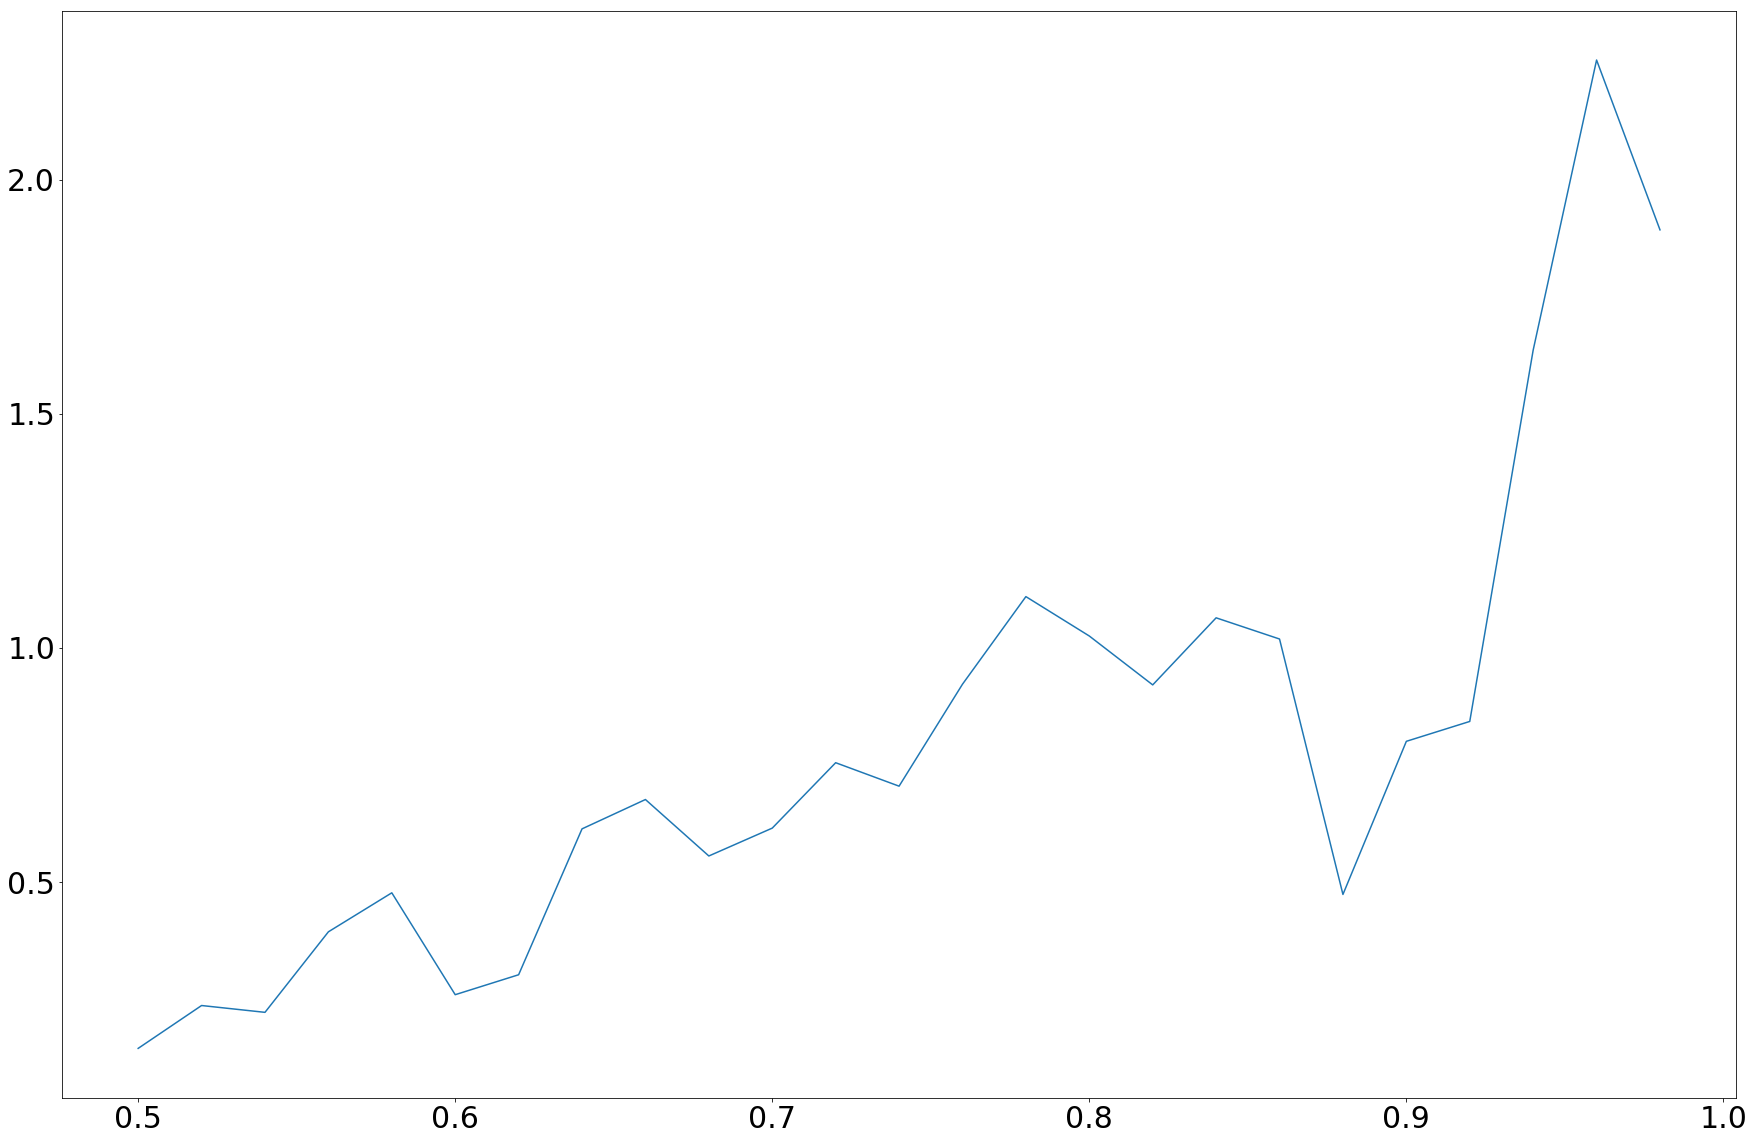

Sharp ratio:  OrderedDict([('sharperatio', 0.0017855729600942808)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.427681789639371), ('moneydown', 68819.91820548824), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.427681789639371), ('moneydown', 68819.91820548824)]))])
SQN: 1.27
Final Portfolio Value: 1001860.31 
Gain: 0.19
Sharp ratio:  OrderedDict([('sharperatio', 0.0012669717999680952)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.430667669171117), ('moneydown', 68779.79746548971), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.430667669171117), ('moneydown', 68779.79746548971)]))])
SQN: 1.27
Final Portfolio Value: 1000779.40 
Gain: 0.08
Sharp ratio:  OrderedDict([('sharperatio', 0.0003096173485499797)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 6.494896379375843), ('moneydown', 69376.69937458856), ('max', AutoOrderedDict([('len', 127), ('drawdown', 6.494896379375843), ('moneydown', 69376.69937458856)]))])
SQN: 1.28
Final

Sharp ratio:  OrderedDict([('sharperatio', 0.003759793215211048)])
Max drwadown:  AutoOrderedDict([('len', 123), ('drawdown', 4.1931993171718185), ('moneydown', 43975.62975218927), ('max', AutoOrderedDict([('len', 123), ('drawdown', 4.1931993171718185), ('moneydown', 43975.62975218927)]))])
SQN: 1.51
Final Portfolio Value: 1004761.30 
Gain: 0.48
Over: 4, t: 0.48


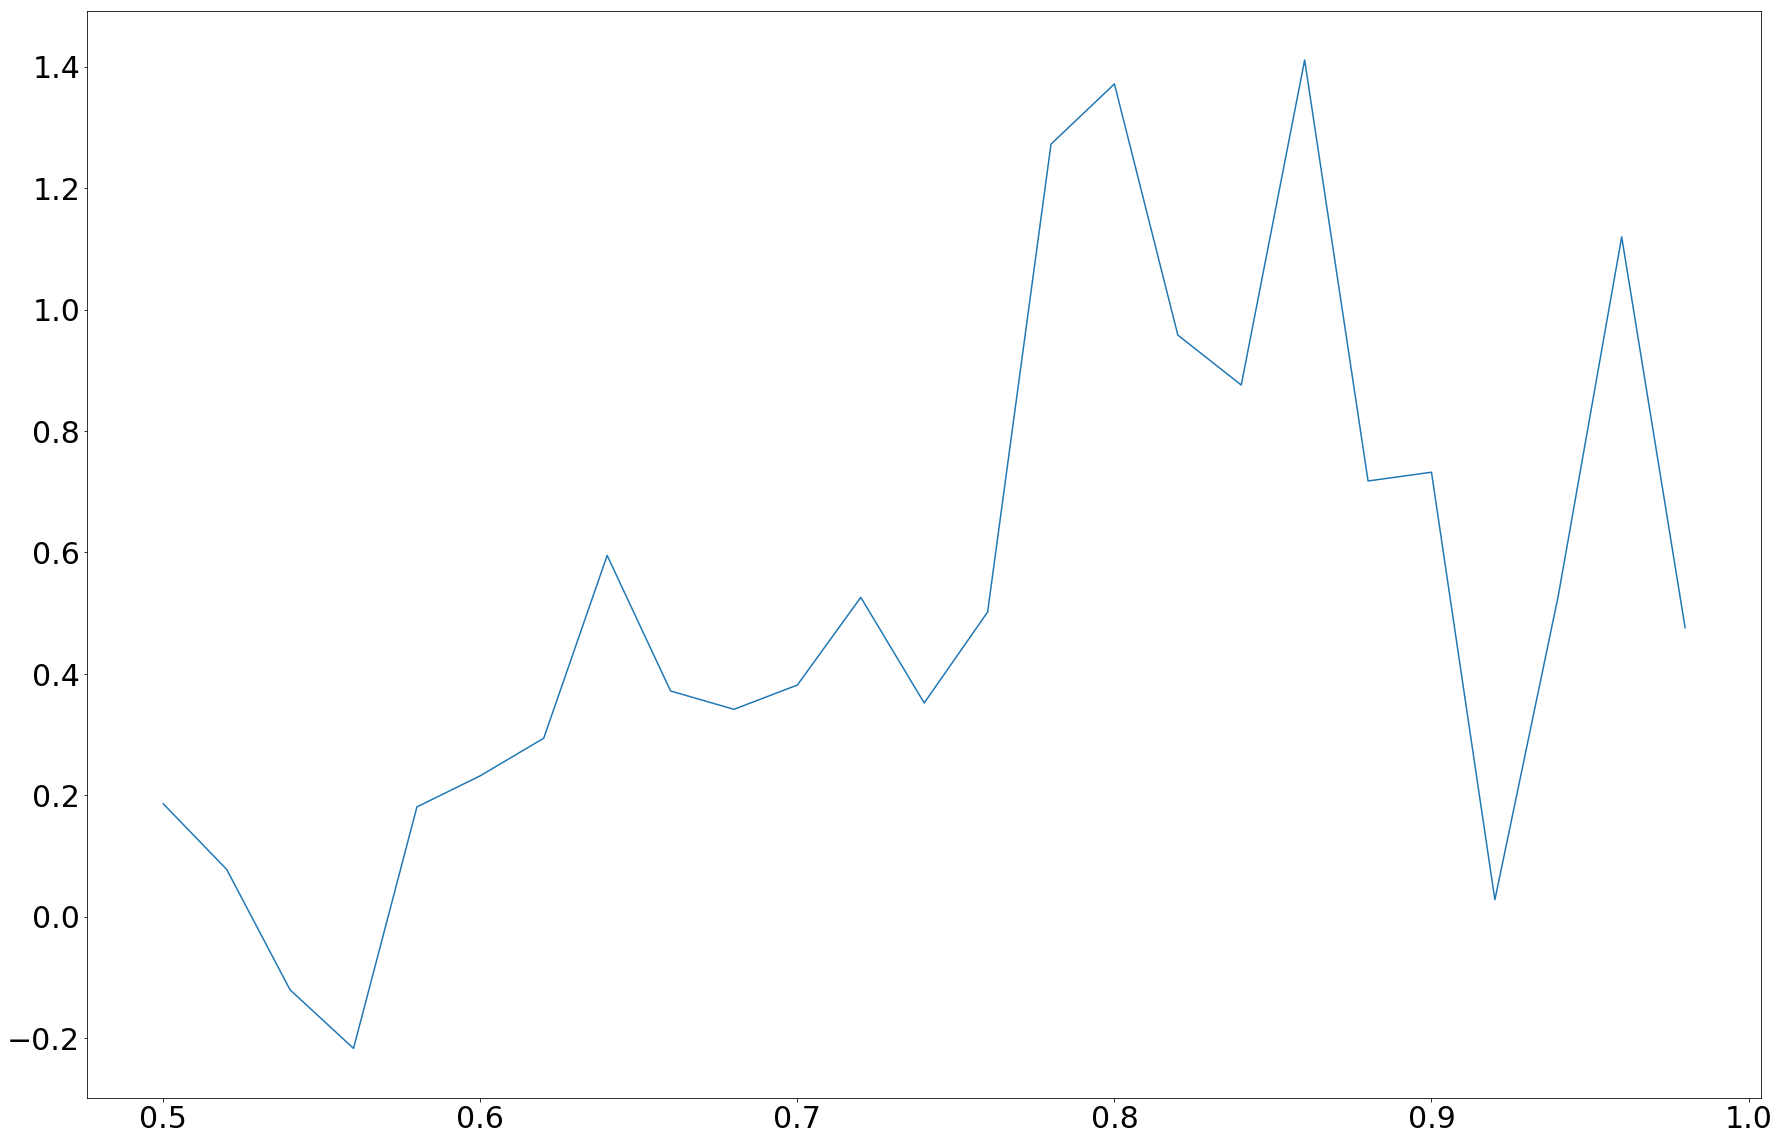

Sharp ratio:  OrderedDict([('sharperatio', -0.0016908018242995683)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.764039873335764), ('moneydown', 60863.72768378828), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.764039873335764), ('moneydown', 60863.72768378828)]))])
SQN: 1.34
Final Portfolio Value: 995057.62 
Gain: -0.49
Sharp ratio:  OrderedDict([('sharperatio', -0.001951985808039891)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.77862917109693), ('moneydown', 60995.16299938853), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.77862917109693), ('moneydown', 60995.16299938853)]))])
SQN: 1.34
Final Portfolio Value: 994534.81 
Gain: -0.55
Sharp ratio:  OrderedDict([('sharperatio', -0.002109333129383817)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.6409322132405775), ('moneydown', 59441.18639129028), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.6409322132405775), ('moneydown', 59441.18639129028)]))])
SQN: 1.35
Fina

Sharp ratio:  OrderedDict([('sharperatio', 0.003065760647377978)])
Max drwadown:  AutoOrderedDict([('len', 124), ('drawdown', 3.79851261411456), ('moneydown', 39617.557964088744), ('max', AutoOrderedDict([('len', 124), ('drawdown', 3.79851261411456), ('moneydown', 39617.557964088744)]))])
SQN: 1.59
Final Portfolio Value: 1003358.00 
Gain: 0.34
Over: 8, t: 0.48


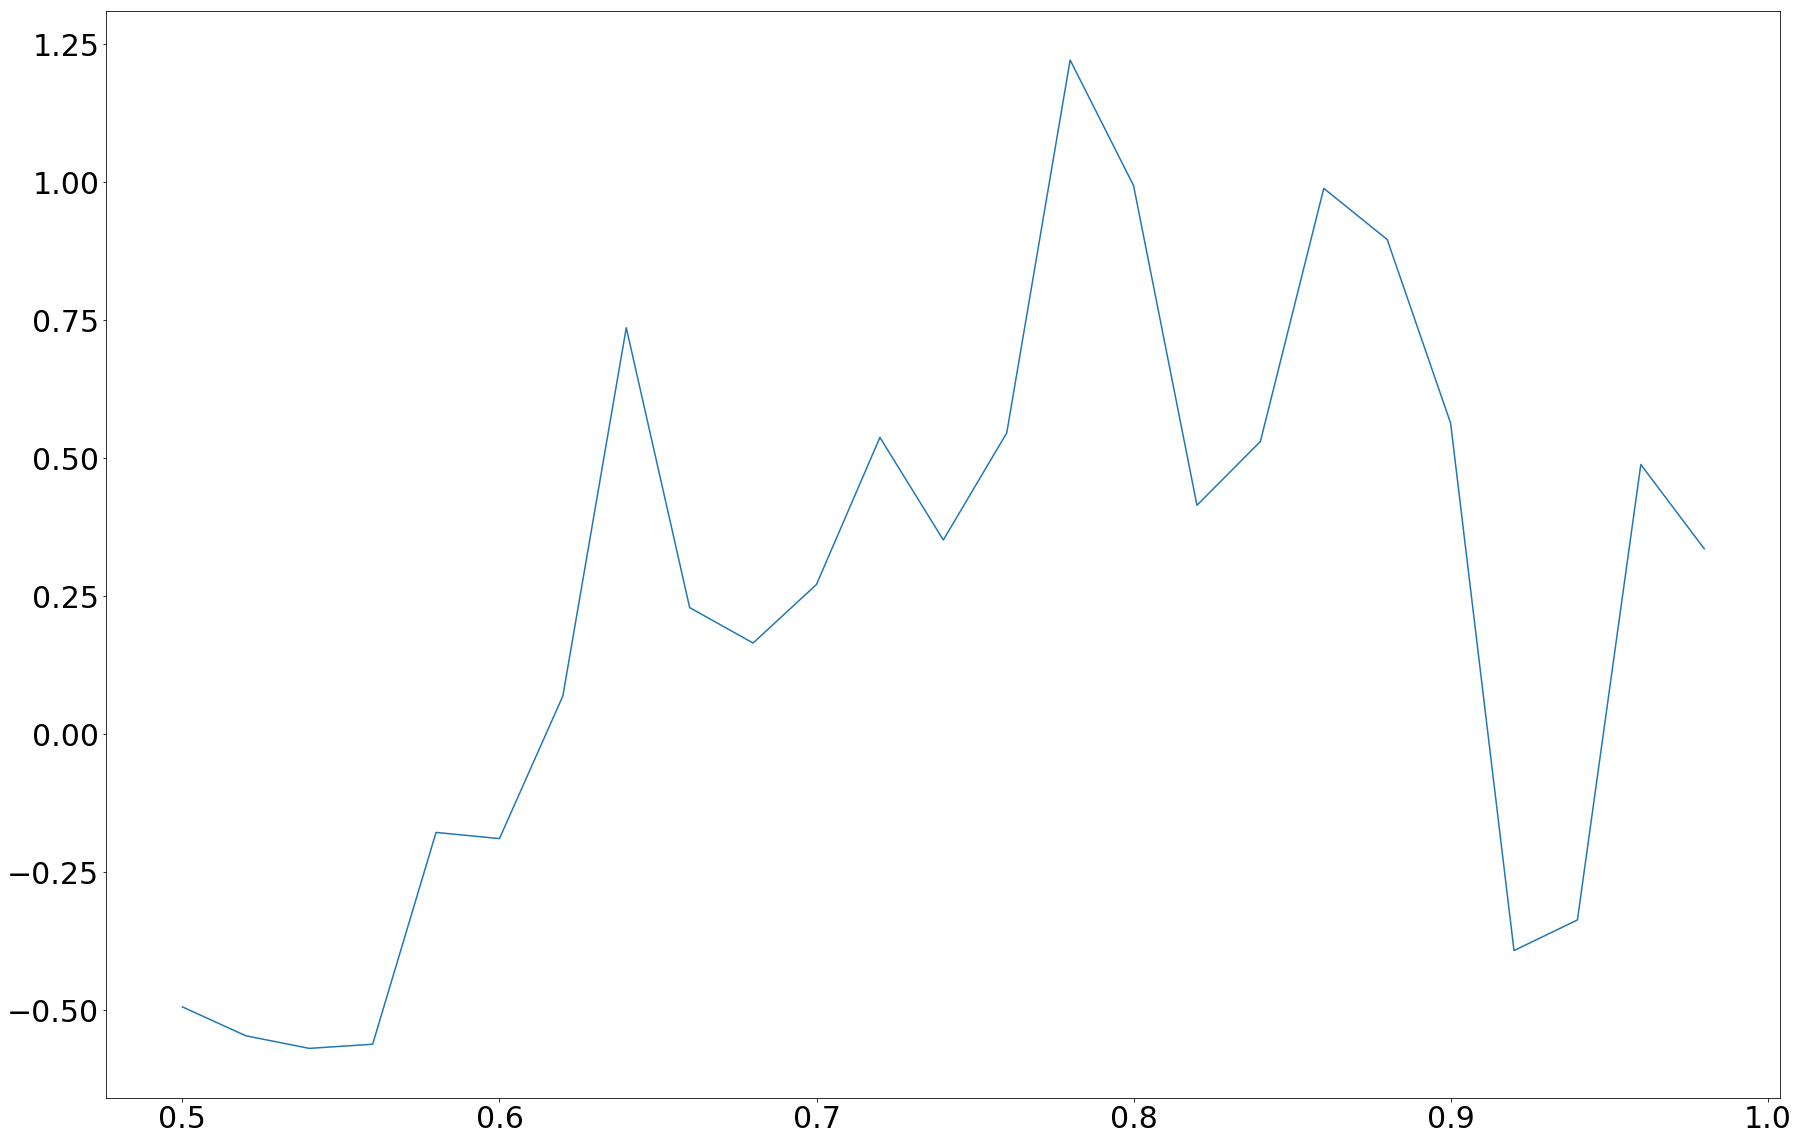

Sharp ratio:  OrderedDict([('sharperatio', -0.007900077769371792)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.308978783801403), ('moneydown', 55176.26458379312), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.308978783801403), ('moneydown', 55176.26458379312)]))])
SQN: 1.17
Final Portfolio Value: 984124.64 
Gain: -1.59
Sharp ratio:  OrderedDict([('sharperatio', -0.007696917046986481)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.320155429535217), ('moneydown', 55322.240684593446), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.320155429535217), ('moneydown', 55322.240684593446)]))])
SQN: 1.19
Final Portfolio Value: 984539.12 
Gain: -1.55
Sharp ratio:  OrderedDict([('sharperatio', -0.007657869067112247)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 5.154333080672885), ('moneydown', 53526.62100689113), ('max', AutoOrderedDict([('len', 127), ('drawdown', 5.154333080672885), ('moneydown', 53526.62100689113)]))])
SQN: 1.18
Fin

Sharp ratio:  OrderedDict([('sharperatio', 0.007930589930779731)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 3.270851265990979), ('moneydown', 34107.37751099712), ('max', AutoOrderedDict([('len', 176), ('drawdown', 3.270851265990979), ('moneydown', 34107.37751099712)]))])
SQN: 2.01
Final Portfolio Value: 1008660.23 
Gain: 0.87
Over: 12, t: 0.48


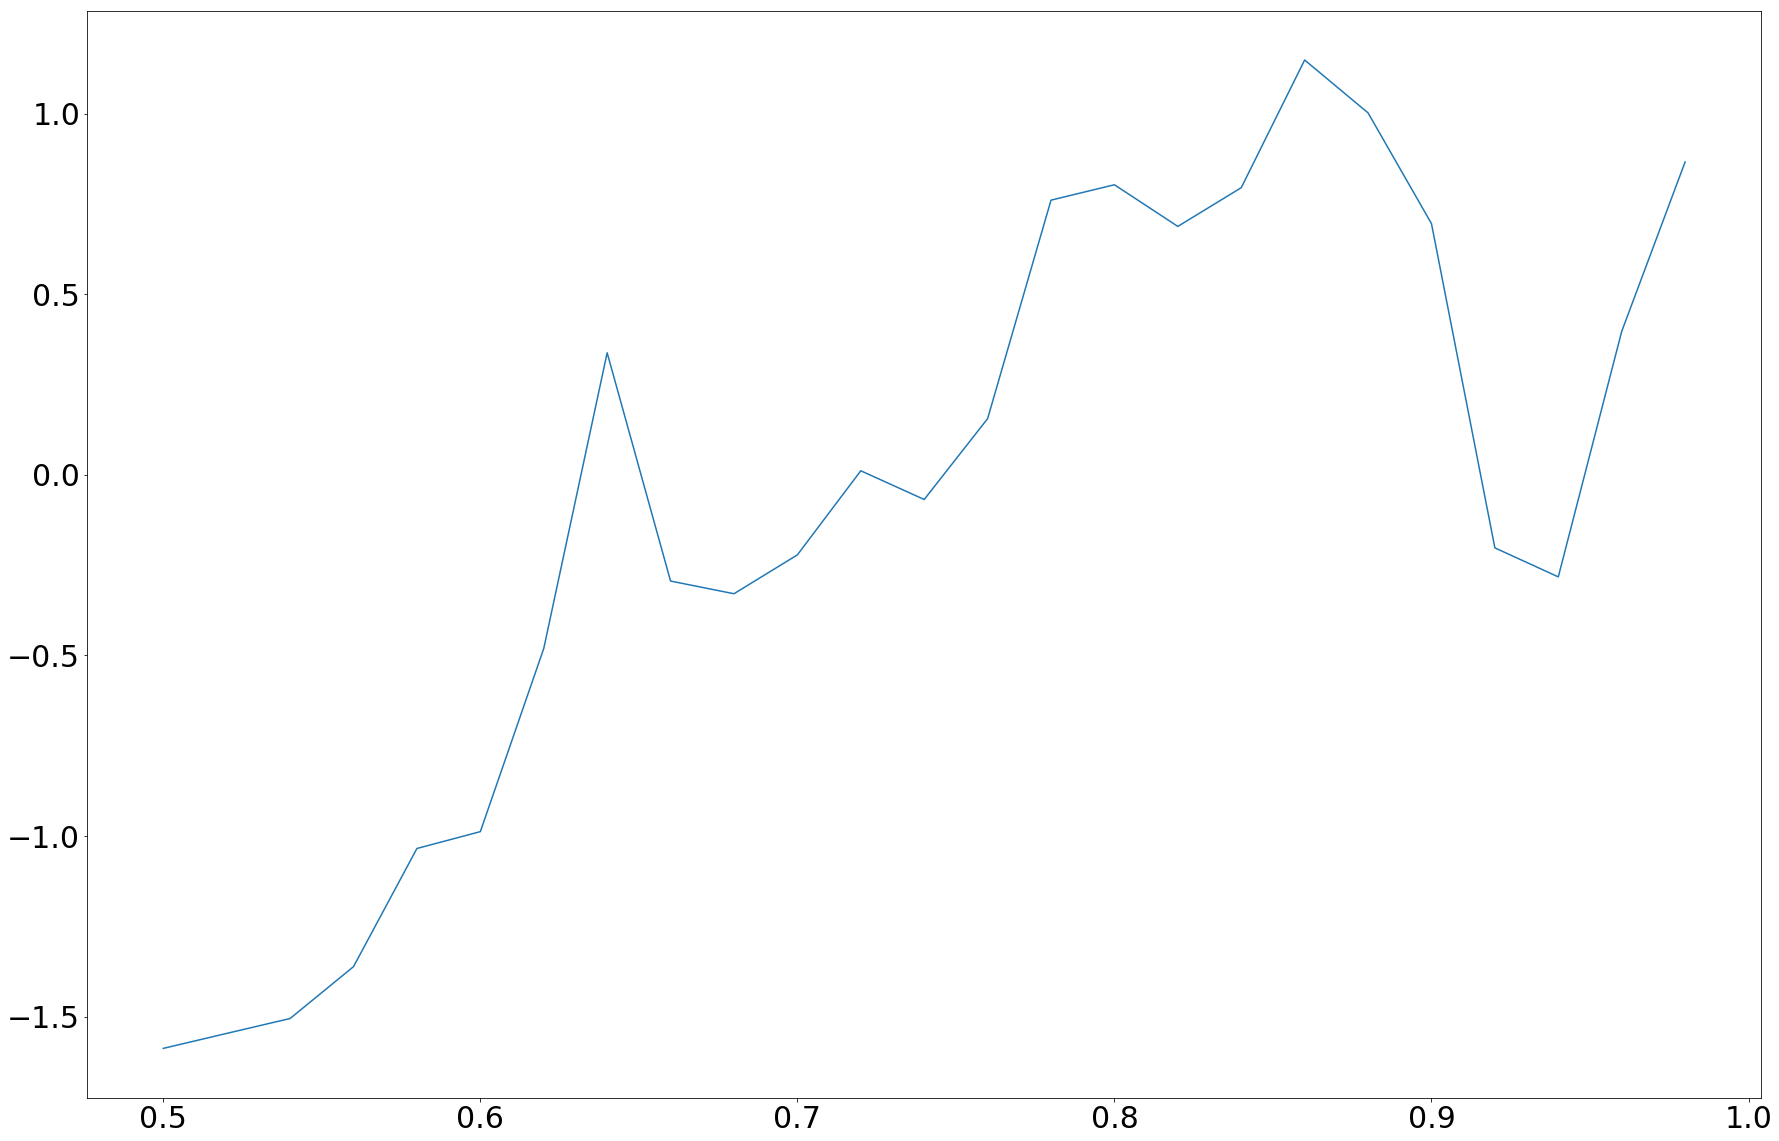

Sharp ratio:  OrderedDict([('sharperatio', -0.012762067748133796)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 5.221539473572471), ('moneydown', 53832.68901589955), ('max', AutoOrderedDict([('len', 176), ('drawdown', 5.221539473572471), ('moneydown', 53832.68901589955)]))])
SQN: 1.12
Final Portfolio Value: 977140.83 
Gain: -2.29
Sharp ratio:  OrderedDict([('sharperatio', -0.01241313758633804)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 5.198815077509941), ('moneydown', 53621.976655699546), ('max', AutoOrderedDict([('len', 176), ('drawdown', 5.198815077509941), ('moneydown', 53621.976655699546)]))])
SQN: 1.15
Final Portfolio Value: 977804.91 
Gain: -2.22
Sharp ratio:  OrderedDict([('sharperatio', -0.013138193441808261)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 5.117619792225893), ('moneydown', 52707.39051219728), ('max', AutoOrderedDict([('len', 176), ('drawdown', 5.117619792225893), ('moneydown', 52707.39051219728)]))])
SQN: 1.14
Fina

Sharp ratio:  OrderedDict([('sharperatio', 0.009988142402878297)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 2.708940611018555), ('moneydown', 28121.272271995666), ('max', AutoOrderedDict([('len', 176), ('drawdown', 2.708940611018555), ('moneydown', 28121.272271995666)]))])
SQN: 1.31
Final Portfolio Value: 1009969.86 
Gain: 1.00
Over: 16, t: 0.48


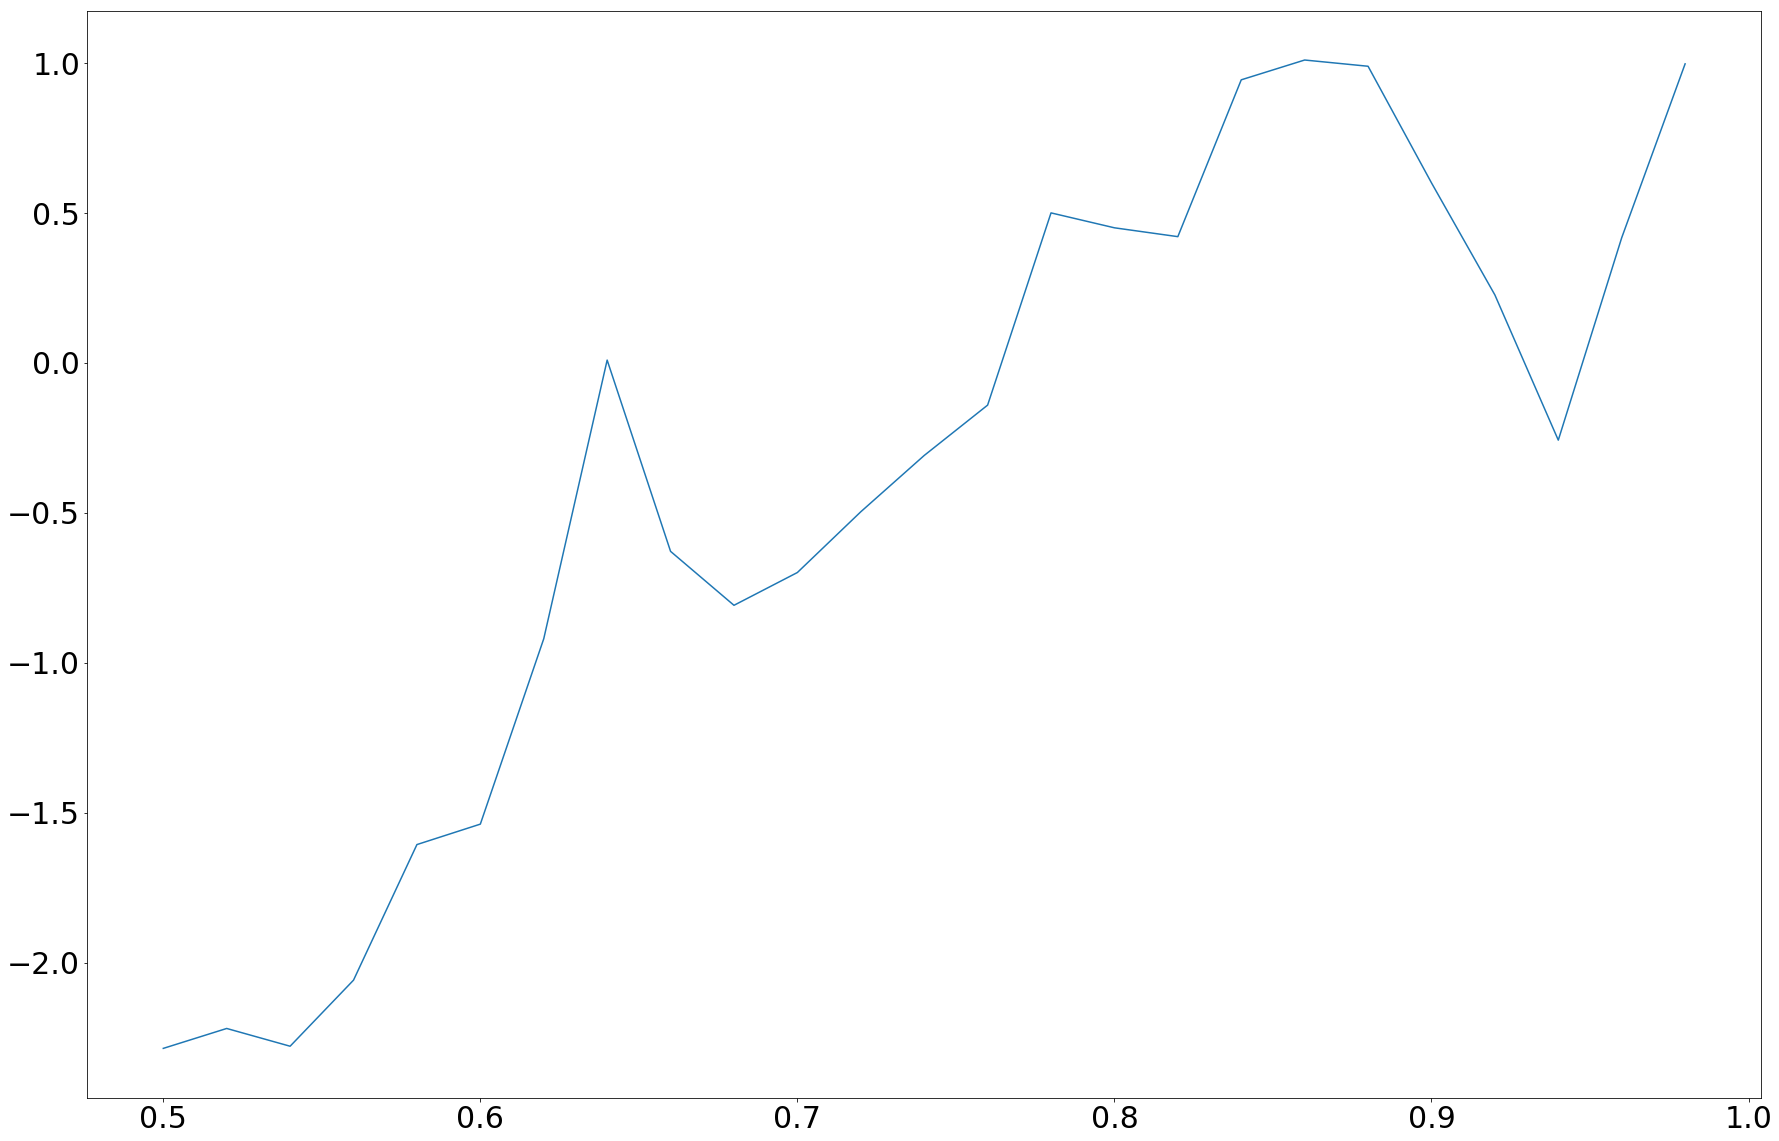

Sharp ratio:  OrderedDict([('sharperatio', -0.01574410111688694)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 4.739033060653532), ('moneydown', 48468.64183509932), ('max', AutoOrderedDict([('len', 127), ('drawdown', 4.739033060653532), ('moneydown', 48468.64183509932)]))])
SQN: 0.99
Final Portfolio Value: 974285.18 
Gain: -2.57
Sharp ratio:  OrderedDict([('sharperatio', -0.01504853327722933)])
Max drwadown:  AutoOrderedDict([('len', 127), ('drawdown', 4.716356605504973), ('moneydown', 48289.41103509953), ('max', AutoOrderedDict([('len', 127), ('drawdown', 4.716356605504973), ('moneydown', 48289.41103509953)]))])
SQN: 1.02
Final Portfolio Value: 975581.66 
Gain: -2.44
Sharp ratio:  OrderedDict([('sharperatio', -0.016024966225780077)])
Max drwadown:  AutoOrderedDict([('len', 176), ('drawdown', 4.625076036131804), ('moneydown', 47272.748913200805), ('max', AutoOrderedDict([('len', 176), ('drawdown', 4.625076036131804), ('moneydown', 47272.748913200805)]))])
SQN: 1.0
Final 

Sharp ratio:  OrderedDict([('sharperatio', 0.01075757235643629)])
Max drwadown:  AutoOrderedDict([('len', 124), ('drawdown', 2.209585761187248), ('moneydown', 22813.509274295415), ('max', AutoOrderedDict([('len', 124), ('drawdown', 2.277402730907626), ('moneydown', 23513.70525439584)]))])
SQN: 1.14
Final Portfolio Value: 1009665.50 
Gain: 0.97
Over: 20, t: 0.48


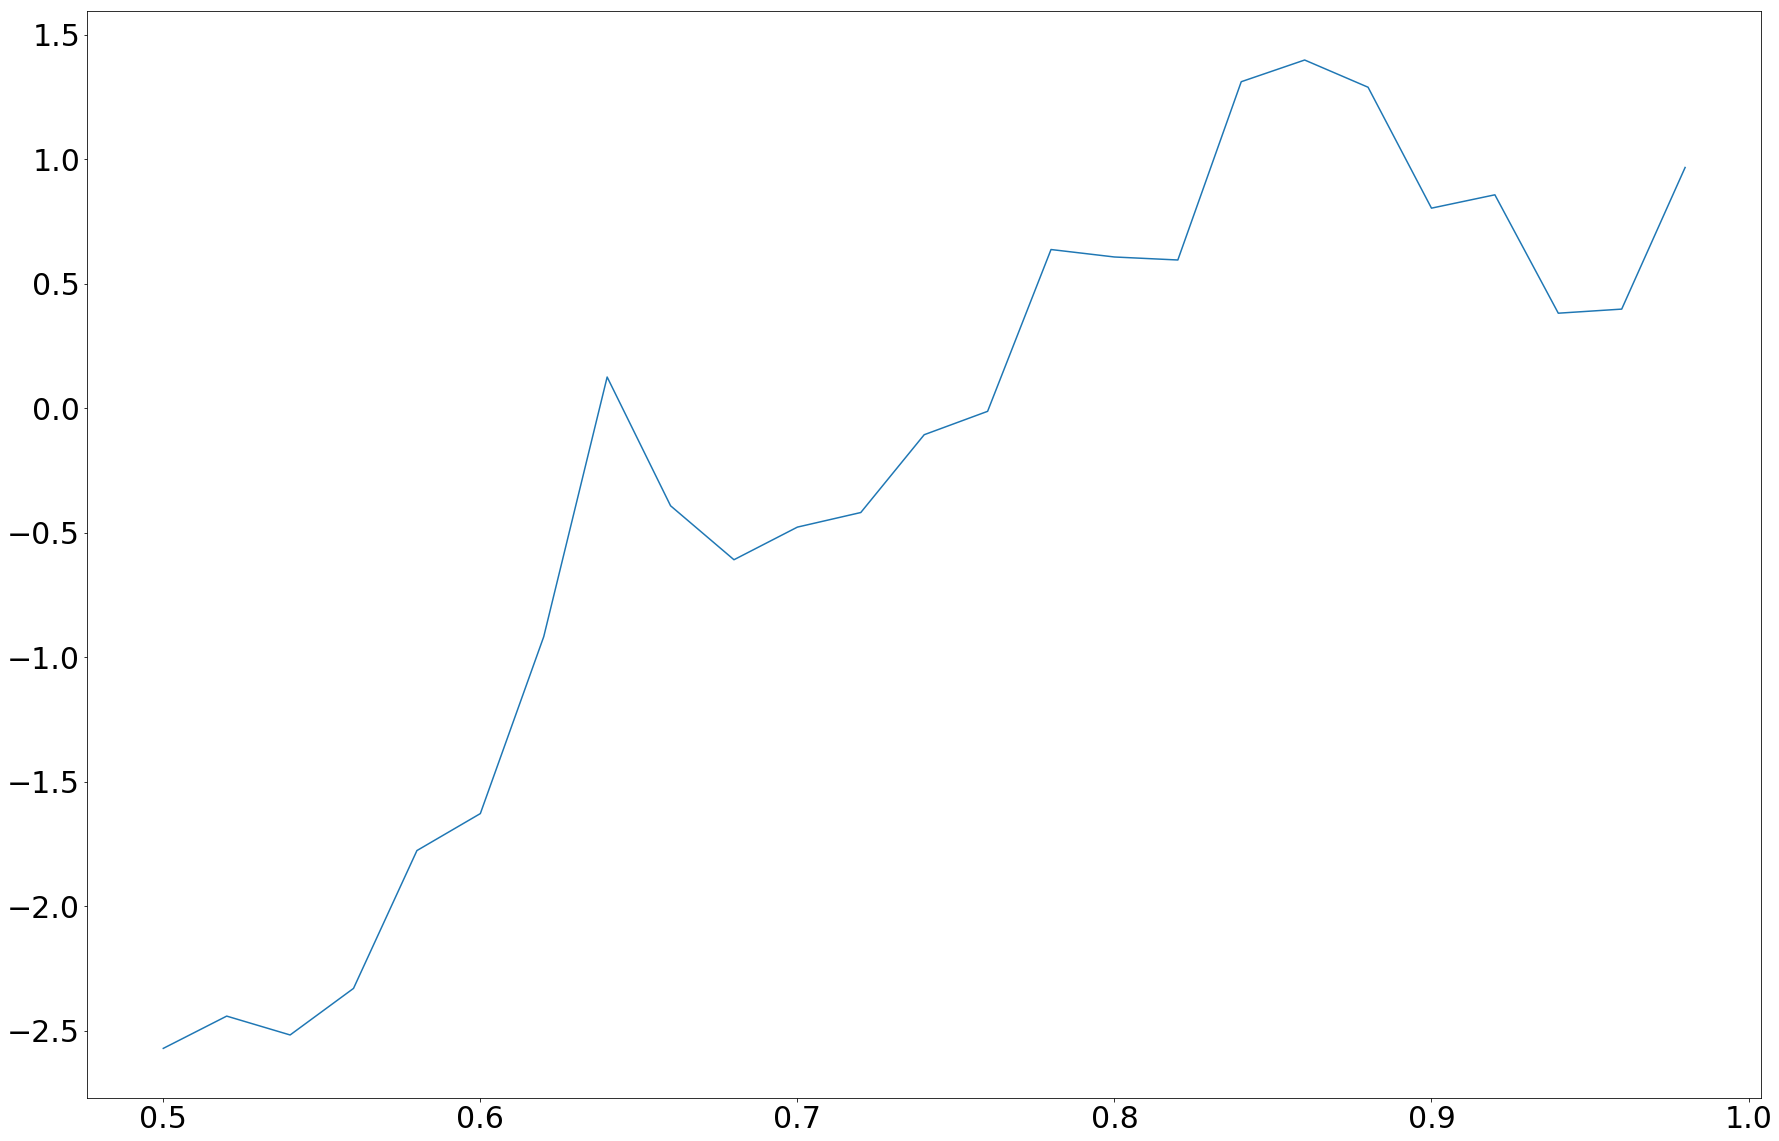

FINAL COMPARISON


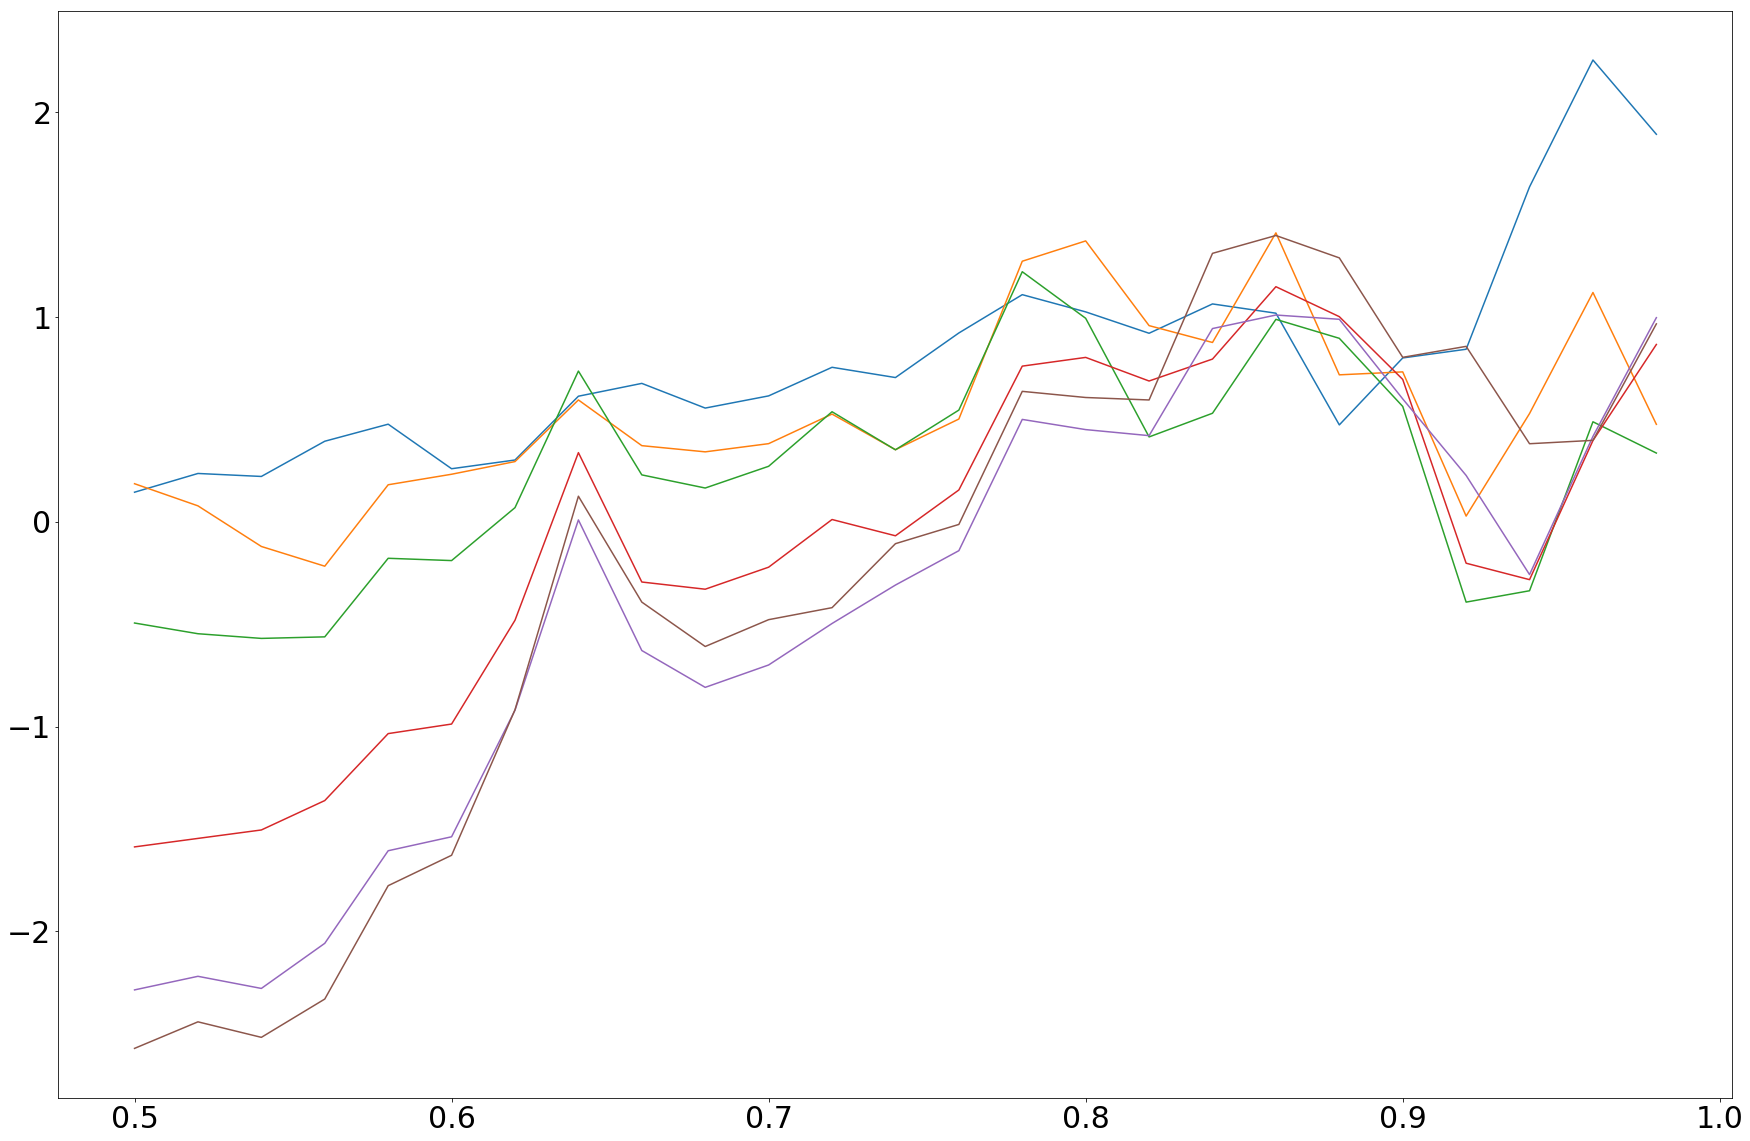

In [30]:
#BOTH
gainlist=list()
for over in [0,4,8,12,16,20]:
    gain=list()
    for t in np.arange(0,0.5,0.02):
        #print('Threshold: ',t)
        gain.append(simulation(t,over,1000000,tickers,1,'both'))
    print('Over: '+str(over)+', t: '+str(t))
    plt.plot(np.arange(0.5,1,0.02),gain)
    plt.show()
    gainlist.append(gain)
print('FINAL COMPARISON')
for el in range(0,len(gainlist)):
    plt.plot(np.arange(0.5,1,0.02),gainlist[el])
plt.show()

In [14]:
for i in range(0,len(gainlist)):
    print(max(gainlist[i]))

8.225220239748433
5.385806231308496
3.591314420700946
1.6448867643303005
2.73480621520062
2.8929511084413972


In [ ]:
gainboth=[5.010853604579484, 4.975160303768608, 5.290465872148751, 5.739085881778877, 5.1826139561980495, 5.048948721668217, 5.549868986768555, 5.81908824842847, 5.908067159249913, 6.16944868928995, 6.39909217057894, 6.660453493949585, 6.667189343709405, 6.583868004797795, 6.688398388167168, 7.074454790347139, 7.822147708539828, 8.866061855020117, 9.687749754490564, 10.178075495800796, 11.092635158809507, 12.902509956311482, 12.605703905601125, 11.911525481200265, 10.499530551260431]
gainnews=[4.175316144942178, 3.9201484055423292, 3.5134852526318396, 3.6301192357513123, 4.125166971131996, 4.417256095291325, 6.018198561211489, 6.962646357551729, 9.006399290161207, 11.008402017971267, 10.604606921081267, 12.167896594091017, 11.78031313538067, 12.285771461050444, 13.324210015120265, 12.347258035990338, 11.645743347420193, 11.3352191591901, 10.847672029770212, 10.356838999190181, 9.964302729130186, 8.213458954809955, 7.981116253049905, 7.376036521119974, 4.8573502508899775]
plt.plot(np.arange(0.5,1,0.02),gainnews)
plt.plot(np.arange(0.5,1,0.02),gainboth)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,2.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,5.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,8.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
gain=list()
for t in np.arange(0,0.5,12.02):
    print('Threshold: ',t)
    gain.append(simulation(t,0,1000000,tickers,1))
plt.plot(np.arange(0.5,1,0.02),gain)
plt.show()

In [ ]:
#do for one ticke time to make plot
for ticker in tickers:
    

    pred_threshold = 0.3        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
    num_pred_over_threshold = 5  #buy if more than this number of prediction over threshold
    init_value = 100000.0


    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobservermulti(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Broker)
    cerebro.addobserver(bt.observers.DrawDown)
    
   
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions=list() 

    evenPlot = True
    
    temppred=pd.read_csv('/home/andrea/Desktop/NLFF/technicalAnalysis/NN/Predictions/Newsetting/both/'+ticker+'.csv')
    predictions.append(temppred)
    #plt.hist(temppred[ticker], bins = np.arange(0.0, 1.0, 0.01))
    #plt.show()
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in temppred['Unnamed: 0']]
    data = bt.feeds.GenericCSVData(
                dataname='/home/andrea/Desktop/NLFF/TechnicalDataset/GMT+0/'+ticker+'.csv',
                name=ticker,
                timeframe = bt.TimeFrame.Minutes, 
                compression = 15,
                datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                fromdate=dates_test[0],
                todate=dates_test[-1]+timedelta(minutes=1),
                reverse=False)
#         if(evenPlot):
#             data0 = data
#             evenPlot = False
#         else:
#             data.plotinfo.plotmaster = data0
#             evenPlot = True
    cerebro.adddata(data)

    #cerebro.addsizer(Sizer)    
     #Up to now only future
    cerebro.addstrategy(Strategy,
                        pred_threshold = pred_threshold,
                        num_pred_over_threshold = num_pred_over_threshold,
                        forecast_window=140,
                        predictions = predictions,
                        verbose = True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe',timeframe=bt.TimeFrame.Minutes, compression=15) 
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    cerebro.plot()
    
    printTradeAnalysis(strategy.analyzers.ta.get_analysis())
    print(strategy.analyzers.sharpe.get_analysis())
    printSQN(strategy.analyzers.sqn.get_analysis())
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, (100*(final_value-init_value))/init_value))

In [ ]:
## MARKET PERFORMANCE:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
      
    def __init__(self):
        return

    def next(self): 
        for i, d in enumerate(self.datas):
            self.buy(data = d, size=1)                


init_value = 3670.0 #Correct value to buy one stock a the beginning
init_value = 100000

for (init, finish) in TREND_WINDOWs:
    print('\n====================  trend: ',init,' ',finish, ' ==================== \n')
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions = pd.read_csv('testPredictions/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
    for ticker in tickers:
        data = bt.feeds.GenericCSVData(
                    dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
                    name=ticker,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 60,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
        cerebro.adddata(data)
        
    cerebro.addstrategy(BuyAndHold)
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))